<a href="https://colab.research.google.com/github/yonitsur/ML-workshop/blob/main/notebooks/Histogram_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import yaml
import sys
import os
from IPython import display
import time
from google.colab import drive
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# if torch.cuda.is_available():

import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything.utils.amg import *
from pycocotools import mask as mask_utils

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-udtr1hcs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-udtr1hcs
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=d75ec51173af7a4a3dbbfeae1d15c4e31bb47ec09a93b5c765f7cd02f2991d44
  Stored in directory: /tmp/pip-ephem-wheel-cache-pzlzf5bf/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
categories = [
      'Metal (general)',
      'Metal (iron bender)',
      'Metal (pipe)',
      'Wood (pallett)',
      'Wood (scraps/cuttings)',
      'Carton',
      'Concrete',
      'Plastic (big bag)',
      'Plastic (bucket)',
      'Plastic (general)',
      'Plastic (pipe)',
      'Plastic (sand bag)',
      'Nylon',
      'Rubber',
      'Textil/Fabric/Cloth',
      'Background',
      'All Background',
      'Unknown',
      'Skip',
      'Back',
      'Exit'
  ]

In [ ]:
folder_path = "/content/drive/MyDrive/Project/Project/data"
project_path = "/content/drive/MyDrive/Project/Project"
# folder_path = "/content/drive/MyDrive/Project/data/Arik"

In [ ]:
images = ['DJI_20230221091035_0034_V', 'DJI_20230221095213_0011_V', 'DJI_20230221100215_0124_V',
          'DJI_20230221081744_0017_V']
split = 0

In [ ]:
# labels_dict = {'Metal (general)':0, 'Metal (iron bender)':0, 'Metal (pipe)':0,
#                'Wood (pallett)':1, 'Wood (scraps/cuttings)':1,
#                'Carton':2,
#                'Concrete':3,
#                'Plastic (big bag)':4, 'Plastic (bucket)':4, 'Plastic (general)':4,
#                'Plastic (pipe)':4, 'Plastic (sand bag)':4,
#                'Nylon':5,
#                'Rubber':6,
#                'Textil/Fabric/Cloth':7,
#                'Background':8,
#                'Unknown':9}
labels_dict = { 'Metal':0,
              'Metal (general)': 0,
              'Metal (iron bender)':0,
              'Metal (pipe)':0,
              'Wood (pallett)':1,
              'Wood (pallet)':1,
              'Wood (scraps/cuttings)':1,
              'Wood': 1,
              'Paper':2,
              'Carton':2,
              'Carton+Paper':2,
              'Nylon':3,
              'Plastic (big bag)':3,
              'Plastic (bucket)':3,
              'Plastic (general)':3,
              'Plastic (pipe)':3,
              'Plastic (sand bag)':3,
              'Plastic':3,
              'Polymers':3,
              'Flexible polymers':3,
              'Rigid polymers':3,
              'Gypsum':4,
              'Concrete':4,
              'Ceramics':4,
              'Construction':4,
              'Mineral':4,
              'Rubber':5,
              'Background':6,

              #others
              'Styrofoam':7,
              'Textil':7,
              'Textil/Fabric/Cloth':7,
              'Glass':7,
              'Other':7,
              'Other(Styrofoam, Textil, Glass)':7
              }

reverse_labels_dict = {0:'Metal',
                1:'Wood',
               2:'Carton+Paper',
               3:'Polymers',
               4:'Mineral',
                5:'Rubber',

               6:'Background',
              7:'Other(Styrofoam, Textil, Glass)'
                       }

In [ ]:
def get_vector(image, mask=None, bins=256):
    red = cv2.calcHist(
        [image], [2], mask, [bins], [0, 256]
    )
    green = cv2.calcHist(
        [image], [1], mask, [bins], [0, 256]
    )
    blue = cv2.calcHist(
        [image], [0], mask, [bins], [0, 256]
    )
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

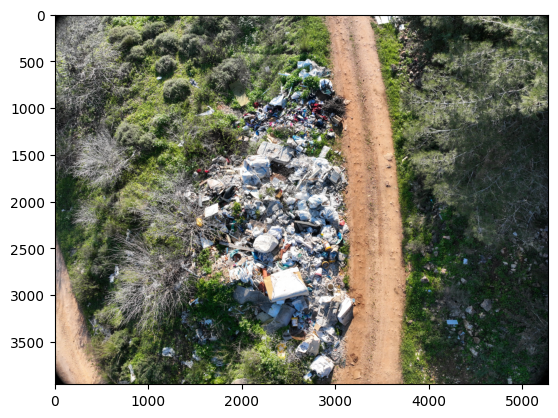

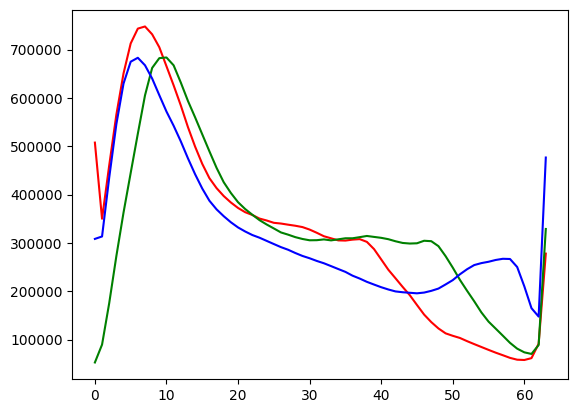

In [ ]:
im_path = f'{folder_path}/Arik/DJI_20230221081744_0017_V'
sp_img = cv2.imread(f'{im_path}/DJI_20230221081744_0017_V.jpg')
sp_img = cv2.cvtColor(sp_img, cv2.COLOR_BGR2RGB)
plt.imshow(sp_img)
plt.show()
red_hist = cv2.calcHist(
    [sp_img], [2], None, [64], [0, 256]
)
green_hist = cv2.calcHist(
    [sp_img], [1], None, [64], [0, 256]
)
blue_hist = cv2.calcHist(
    [sp_img], [0], None, [64], [0, 256]
)
# vec = get_vector(sp_img)
plt.plot(red_hist, color='r')
plt.plot(green_hist, color='g')
plt.plot(blue_hist, color='b')
# plt.axis('off')
plt.show()
# plt.plot()

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
import json
import copy
with open(f'{project_path}/jsons/annotations.json') as f:
  json_dict1 = json.load(f)
a = copy.deepcopy(json_dict1)

In [ ]:
with open(f'{project_path}/jsons/segs.json') as f:
  seg = json.load(f)

In [ ]:
NORMALIZE = True

In [ ]:
sizes = {}

In [ ]:
class SplitDatasetMaskedResized(Dataset):
  def __init__(self, path, owner, image_name, sp, rotation=0, flip=None, color_aug=False, local=False):
    self.image_name = image_name
    self.sp = sp
    self.local = local
    self.folder_path = path
    self.owner = owner
    self.seg=seg
    self.rotation=rotation
    self.flip = flip
    self.color_aug = color_aug
    self.im_path = f'{self.folder_path}/{owner}/{image_name}'
    self.split_path = f'{self.im_path}/split_{sp}'
    # with open(f'{self.split_path}/seg_{sp}.yaml') as f:
    #   self.seg = yaml.safe_load(f)
    files_in_folder = os.listdir(self.split_path)
    self.ann_dict={image_name:{sp:{}}}
    if f'anns_{sp}.yaml' in files_in_folder:
      with open(f'{self.split_path}/anns_{sp}.yaml', 'r') as f:
        self.ann_dict = yaml.safe_load(f)
        # print(self.ann_dict)
        # if len(self.ann_dict[self.image_name][self.sp]) == 0:
        #   self.ann_dict.update(json_dict1)
        # elif self.image_name in json_dict1:
        #   for mask in json_dict1[self.image_name][self.sp]:
        #     if mask in self.ann_dict[self.image_name][self.sp]:
        #       if self.ann_dict[self.image_name][self.sp][mask]!=json_dict1[self.image_name][self.sp][mask]:
        #         print(self.image_name, self.sp, mask)
        #     else:
        #       self.ann_dict[self.image_name][self.sp][mask] = json_dict1[self.image_name][self.sp][mask]
        #print(self.image_name, self.sp)
        # Remove all unknowns
    if self.image_name in json_dict1 and self.sp in json_dict1[self.image_name]:
      self.ann_dict[self.image_name][self.sp].update(json_dict1[self.image_name][self.sp])

    # discarded = len([a for a in self.ann_dict[self.image_name][self.sp].values() if a in ['Paper', 'Rubber', 'Glass']])
    # self.others = discarded

    self.ann_dict[self.image_name][self.sp] = {key:val for key, val in self.ann_dict[self.image_name][self.sp].items()
      if val in labels_dict.keys() and key in self.seg[image_name][f'split_{sp}'] and self.seg[image_name][f'split_{sp}'][key]['area'] > 2000}
        # TODO: eliminate masks that are too small


  def __len__(self):
    return len(self.ann_dict[self.image_name][self.sp])

  def __getitem__(self, idx):
    annotated_masks = list(self.ann_dict[self.image_name][self.sp].keys())
    # self.sizes = np.zeros((len(annotated_masks),2))
    m = annotated_masks[idx]
    if not self.local:
      fp = folder_path # Take care of differences when working on colab vs locally
    else:
      fp = folder_path
    img = cv2.imread(f'{fp}/{self.owner}/{self.image_name}/split_{self.sp}/{m}.jpg')
    # print(self.image_name, self.sp, m)
    # feat = get_texture_features(img)
    # mean = feat.mean(1)
    # std = feat.std(1)
    # feat = (feat - mean)/std
    # with open(f'{self.split_path}/seg_{self.sp}.yaml') as f:
    #   self.seg = yaml.safe_load(f)
    # self.seg
    feat = torch.Tensor(self.seg[self.image_name][f'split_{self.sp}'][m]['textures'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)


    if self.rotation != 0:
      im_pil = im_pil.rotate(self.rotation, Image.NEAREST, expand=1)
      # image = im_pil
      # image_array = np.array(image)
      # lower_threshold = np.array([20, 20, 20])  # Minimum color values
      # upper_threshold = np.array([255, 255, 255])  # Maximum color values
      # binary_mask = np.all((image_array >= lower_threshold) & (image_array <= upper_threshold), axis=-1)
      # object_pixels = np.where(binary_mask)

      # min_y, min_x = np.min(object_pixels, axis=1)
      # max_y, max_x = np.max(object_pixels, axis=1)
      # im_pil=im_pil.crop((min_x,min_y,max_x,max_y))

    if self.flip != None:
      if self.flip == "h":
        im_pil = im_pil.transpose(Image.FLIP_LEFT_RIGHT)
      elif self.flip == "v":
        im_pil = im_pil.transpose(Image.FLIP_TOP_BOTTOM)

    if (self.seg[self.image_name][f'split_{self.sp}'][m]['area']/(im_pil.size[0]*im_pil.size[1]))<0.4:
      best_coverage = 0
      best_img = im_pil
      for _ in [15,30,45,60,75,90]:
        im_pil = im_pil.rotate(_, Image.NEAREST, expand=1)
        image = im_pil
        image_array = np.array(image)
        lower_threshold = np.array([20, 20, 20])  # Minimum color values
        upper_threshold = np.array([255, 255, 255])  # Maximum color values
        binary_mask = np.all((image_array >= lower_threshold) & (image_array <= upper_threshold), axis=-1)
        object_pixels = np.where(binary_mask)

        min_y, min_x = np.min(object_pixels, axis=1)
        max_y, max_x = np.max(object_pixels, axis=1)
        coverage = np.sum(binary_mask)/((max_x-min_x)*(max_y-min_y))

        # print(_, coverage)
        bbox_image = Image.fromarray(image_array[min_y:max_y+1, min_x:max_x+1])
        bbox_image.save("bounding_box.png")
        bbox_image.show()

        # Bounding box coordinates
        im_pil=im_pil.crop((min_x,min_y,max_x,max_y))
        if(coverage>best_coverage):
          best_coverage = coverage
          best_img = im_pil
        im_pil = im_pil.rotate(-_, Image.NEAREST, expand=1)

      im_pil = best_img

    sizes[str(feat.detach())] = self.owner, self.image_name, self.sp, m, im_pil.size

    preprocess0 = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor()
    ])
    preprocess1 = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    preprocess2 = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
    ])
    # input_tensor = preprocess(im_pil)
    if NORMALIZE:
        if self.color_aug:
          input_tensor = preprocess2(im_pil)
        else:
          input_tensor = preprocess1(im_pil)
    else:
        input_tensor = preprocess0(im_pil)

    # mask = rle_to_mask(self.seg[self.image_name][self.sp][m]['segmentation'])
    label = self.ann_dict[self.image_name][self.sp][m]
    y = labels_dict[label]
    return input_tensor, feat, y

In [ ]:
ds = torch.load(f'{project_path}/datasets/all_set_final_for_paper.pt')

In [ ]:
class_images = {c:[] for c in reverse_labels_dict.values()}
for im, feat, y in tqdm(ds):
    owner, image_name, sp, m, size = sizes[str(feat)]
    # im_path = f'{folder_path}/{image}'
    # for sp in range(16):
    #     split_path = f'{im_path}/split_{sp}'
    #     with open(f'{split_path}/seg_{sp}.yaml') as f:
    #         seg = yaml.safe_load(f)
    #     files_in_folder = os.listdir(split_path)
    #     ann_dict={image:{sp:{}}}
    #     if f'anns_{sp}.yaml' in files_in_folder:
    #         with open(f'{split_path}/anns_{sp}.yaml', 'r') as f:
    #             ann_dict = yaml.safe_load(f)
    #     for mask in ann_dict[image][sp].keys():
    # if json_dict1[image][sp][mask] == 'Unknown':
    #     continue
    # sp_img = cv2.imread(f'{split_path}/split_{sp}.jpg')
    # sp_img = cv2.cvtColor(sp_img, cv2.COLOR_BGR2RGB)
    # inp = im.numpy().transpose((1, 2, 0))
    # if NORMALIZE:
    #   mean = np.array([0.485, 0.456, 0.406])
    #   std = np.array([0.229, 0.224, 0.225])
    #   inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    img = cv2.imread(f'{folder_path}/{owner}/{image_name}/split_{sp}/split_{sp}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle_to_mask(seg[image_name][f'split_{sp}'][m]['segmentation']).astype("uint8")
    # print(mask.shape, img.shape)
    vec = get_vector(img, mask)
    # print(vec)
    class_images[reverse_labels_dict[y]].append(vec)

v = {}
for cl in class_images.keys():
    v[cl] = np.array(class_images[cl]).mean(axis=0)


100%|██████████| 17268/17268 [1:58:33<00:00,  2.43it/s]


In [ ]:
v['Rubber'] = np.zeros(256*3)

In [ ]:
def calc_similarity(img, mask):
    vec = get_vector(img, mask)
    sim = {}
    for c in v.keys():
        sim[c] = np.dot(vec, v[c]) / (np.linalg.norm(vec) * np.linalg.norm(v[c]))
    sim['Rubber'] = 0
    return sim

In [ ]:
img = 'DJI_20230221091035_0034_V'
sp = 0
#masks = []
# real = []
acc = []
confusion_matrix = torch.zeros(8, 8)
masks = {}
real = {}
count = 0
for im, feat, y in tqdm(ds):
    count +=1
    owner, image_name, sp, m, size = sizes[str(feat)]
    # im_path = f'{folder_path}/{image}'
    # for sp in range(16):
    #     split_path = f'{im_path}/split_{sp}'
    #     with open(f'{split_path}/seg_{sp}.yaml') as f:
    #         seg = yaml.safe_load(f)
    #     files_in_folder = os.listdir(split_path)
    #     ann_dict={image:{sp:{}}}
    #     if f'anns_{sp}.yaml' in files_in_folder:
    #         with open(f'{split_path}/anns_{sp}.yaml', 'r') as f:
    #             ann_dict = yaml.safe_load(f)
    #     for mask in ann_dict[image][sp].keys():
    # if json_dict1[image][sp][mask] == 'Unknown':
    #     continue
    # sp_img = cv2.imread(f'{split_path}/split_{sp}.jpg')
    # sp_img = cv2.cvtColor(sp_img, cv2.COLOR_BGR2RGB)
    # inp = im.numpy().transpose((1, 2, 0))
    # if NORMALIZE:
    #   mean = np.array([0.485, 0.456, 0.406])
    #   std = np.array([0.229, 0.224, 0.225])
    #   inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    img = cv2.imread(f'{folder_path}/{owner}/{image_name}/split_{sp}/split_{sp}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle_to_mask(seg[image_name][f'split_{sp}'][m]['segmentation']).astype("uint8")
    similarities = calc_similarity(img, mask)
    # print(similarities)
    best_idx = np.array(list(similarities.values())).argmax()
    #masks.append((seg[img][sp][mask], best_idx))
    # masks[img][sp].append((seg[img][sp][mask], best_idx))
    # # y = labels_dict[ann_dict[img][sp][mask]]
    # real[img][sp].append((seg[img][sp][mask], y))
    acc.append(best_idx == y)
    confusion_matrix[y, best_idx] += 1
    if count > len(ds)//10:
      break

# print("mask accuracy is", np.array(acc).mean())
# print('Per class accuracy:',confusion_matrix.diag()/confusion_matrix.sum(1))

 10%|▉         | 1726/17268 [01:34<14:12, 18.23it/s]


In [ ]:
all_acc = np.array(acc).mean()
per_calss_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
class_acc = {}
for i,k in enumerate(class_images.keys()):
  class_acc[k] = per_calss_acc[i].item()

In [ ]:
print(f'Accuracy across all classes: {all_acc}')
print()
class_acc

Accuracy across all classes: 0.3821656050955414



{'Metal': 0.0714285746216774,
 'Wood': 0.3199999928474426,
 'Carton+Paper': 0.0544959120452404,
 'Polymers': 0.3008130192756653,
 'Mineral': 0.39939025044441223,
 'Rubber': 0.0,
 'Background': 0.6791045069694519,
 'Other(Styrofoam, Textil, Glass)': 0.0}

In [ ]:
def show_anns(anns, col):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x[0]['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in anns:
        m = rle_to_mask(ann[0]['segmentation'])
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = col[ann[1]]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

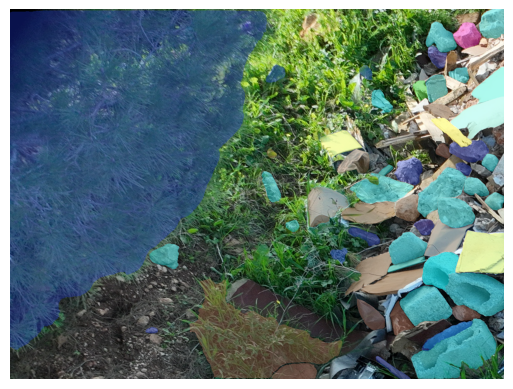

In [ ]:
img = 'DJI_20230221091035_0034_V'
folder_path = "/content/drive/MyDrive/Project/data/Arik"
sp = 0
imm= cv2.imread(f'{folder_path}/{img}/split_{sp}/split_{sp}.jpg')
imm = cv2.cvtColor(imm, cv2.COLOR_BGR2RGB)
with open(f'{folder_path}/{img}/split_{sp}/seg_{sp}.yaml') as f:
      seg = yaml.safe_load(f)
anns = [seg[img][sp]['mask_21']]
# col = np.random.random((9, 3)).tolist()
col=[
    [0.11272985359514087, 0.21481558007872792, 0.8597408646871879],#purple
    [0.0029562409265375678, 0.9426849800137815, 0.9675550964751581],#light blue
    [0.9864670364783911, 0.054673214000644066, 0.8801416409926925],#pink
    [0.060526989119718655, 0.9323238303295093, 0.09792772954892803],#green
    [0.9987179082415893, 0.9920853483841138, 0.082597291685506],#yellow
    [0.4999280120199472, 0.28598707315501437, 0.11109426769635],# brown
    [0.9770520509384132, 0.559578851665699, 0.22018327989146058],# orange
    np.random.random((1, 3)).tolist()[0],
    np.random.random((1, 3)).tolist()[0]]
plt.imshow(imm)
show_anns(masks[img][sp],col)
# show_anns2(anns)
plt.axis('off')
plt.show()


In [ ]:
len(masks)

3923

In [ ]:
# col = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8]
# show_anns(masks, col)
# plt.axis('off')
# plt.show()

# plt.imshow(cv2.imread(f'{folder_path}/{img}/split_{sp}/split_{sp}.jpg'))
# show_anns(real, col)
# plt.axis('off')
# plt.show()